<a href="https://colab.research.google.com/github/Abhiraj36/HumanEmotionsDetection/blob/main/Human_Emotions_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, GlobalAveragePooling2D, Conv2D, MaxPool2D, Dense
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, TopKCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import L2,L1
from tensorflow.keras.layers import Resizing, Rescaling
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam



import matplotlib.pyplot as plt
import numpy as np


In [2]:
from google.colab import files
files.upload()  # Upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abhirajaryan","key":"a77a4658fd915b6eb723a372ffec2a61"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
import kagglehub

# Download latest version of the new dataset
path = kagglehub.dataset_download("himanshuydv11/facial-emotion-dataset")
print(" Path to dataset files:", path)


 Path to dataset files: /kaggle/input/facial-emotion-dataset


In [5]:
import os

# See what folders you got
print(os.listdir(path))


['facial_emotion_dataset']


In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("muhammadhananasghar/human-emotions-datasethes")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/human-emotions-datasethes


In [7]:
import os
import shutil

new_dataset_path = "/root/.cache/kagglehub/datasets/himanshuydv11/facial-emotion-dataset/versions/1/facial_emotion_dataset/dataset"
existing_dataset_path = "/root/.cache/kagglehub/datasets/muhammadhananasghar/human-emotions-datasethes/versions/4/Human_Emotion_Dataset"

# Only copy selected classes
selected_classes = ['Sad', 'Angry', 'Happy']

for cls in selected_classes:
    src = os.path.join(new_dataset_path, cls)
    dst = os.path.join(existing_dataset_path, cls)

    if not os.path.exists(dst):
        os.makedirs(dst)

    for file_name in os.listdir(src):
        src_file = os.path.join(src, file_name)
        dst_file = os.path.join(dst, file_name)
        if os.path.isfile(src_file):
            shutil.copy(src_file, dst_file)

print(" Selected classes merged successfully!")





 Selected classes merged successfully!


In [8]:
import os
import shutil
import random

new_dataset_path = "/root/.cache/kagglehub/datasets/himanshuydv11/facial-emotion-dataset/versions/1/facial_emotion_dataset/dataset"
base_dataset_path = "/content/Human_Emotion_Dataset/EmotionsDataset_Splitted/data"
selected_classes = ["angry", "happy", "sad"]

for cls in selected_classes:
    src_dir = os.path.join(new_dataset_path, cls.capitalize())  # Capitalize because folders are like 'Angry'
    train_dst = os.path.join(base_dataset_path, "train", cls)
    test_dst = os.path.join(base_dataset_path, "test", cls)

    if not os.path.exists(train_dst): os.makedirs(train_dst)
    if not os.path.exists(test_dst): os.makedirs(test_dst)

    files = [f for f in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, f))]
    random.shuffle(files)
    split_idx = int(0.8 * len(files))  # 80% train

    for f in files[:split_idx]:
        shutil.copy(os.path.join(src_dir, f), os.path.join(train_dst, f))
    for f in files[split_idx:]:
        shutil.copy(os.path.join(src_dir, f), os.path.join(test_dst, f))

print(" New data successfully added to train and test folders!")



 New data successfully added to train and test folders!


In [9]:
import os

dataset_path = "/content/Human_Emotion_Dataset"
train_directory = os.path.join(dataset_path, "EmotionsDataset_Splitted", "data", "train")
val_directory = os.path.join(dataset_path, "EmotionsDataset_Splitted", "data", "test")

print("Updated train path:", train_directory)
print("Updated validation path:", val_directory)

CLASS_NAMES = ["angry", "happy", "sad"]


Updated train path: /content/Human_Emotion_Dataset/EmotionsDataset_Splitted/data/train
Updated validation path: /content/Human_Emotion_Dataset/EmotionsDataset_Splitted/data/test


In [10]:
# Configuration dictionary
CONFIGURATION = {
    "IM_SIZE": 256,
    "N_FILTERS": 6,
    "KERNEL_SIZE": (5, 5),
    "N_STRIDES": 1,
    "POOL_SIZE": (2, 2),
    "DROPOUT_RATE": 0.25,
    "REGULARIZATION_RATE": 0.0001,
    "N_DENSE_1": 120,
    "N_DENSE_2": 84,
    "NUM_CLASSES": 3,  # Adjust based on dataset
    "BATCH_SIZE": 32
}

In [11]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='int',
    image_size=(256, 256),
    batch_size=32,
    shuffle=True,
    seed=99,
    class_names=CLASS_NAMES,
    color_mode='rgb'
)


Found 8923 files belonging to 3 classes.


In [12]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_directory,  # Now pointing to test directory
    labels='inferred',
    label_mode='int',
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    batch_size=CONFIGURATION["BATCH_SIZE"],
    shuffle=True,  # Usually, we don't shuffle validation data
    seed=99,
    class_names=CLASS_NAMES,
    color_mode='rgb'
)


Found 4403 files belonging to 3 classes.


In [13]:
for images, labels in val_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch:", labels.numpy())


Image batch shape: (32, 256, 256, 3)
Label batch: [1 2 1 2 2 0 1 0 2 2 2 0 0 0 1 2 1 1 0 0 2 1 2 0 2 1 1 1 0 2 2 1]


Data Visualization

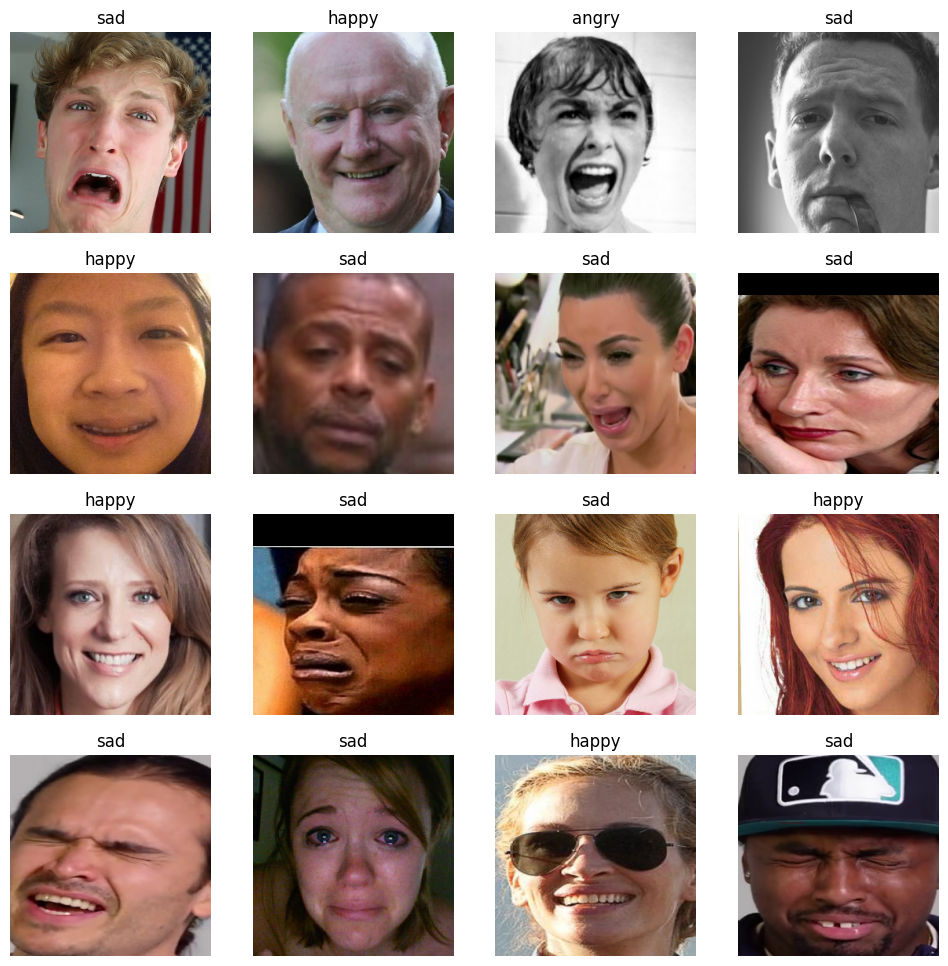

In [14]:
plt.figure(figsize=(12, 12))

for images, labels in train_dataset.take(1):  # Taking one batch of images
    for i in range(min(16, len(images))):  # Display up to 16 images
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert tensor to image
        plt.title(CLASS_NAMES[labels[i].numpy()])  # Get class name
        plt.axis("off")  # Hide axes

plt.show()


Dataset Preparation

In [15]:
training_dataset = (
    train_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [16]:
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)


In [17]:
IM_SIZE = 256  # Define the image size if not already defined

resize_rescale_layers = tf.keras.Sequential([
    Resizing(IM_SIZE, IM_SIZE),
    Rescaling(1.0 / 255),  # Normalize pixel values to [0,1]
])

Building and Applying Model

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers



data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


# Define the model
lenet_model = tf.keras.Sequential([
    layers.Input(shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3)),  # Fixed input shape warning
    data_augmentation,
    layers.Rescaling(1./255, name="rescaling"),

    layers.Conv2D(filters=CONFIGURATION["N_FILTERS"], kernel_size=CONFIGURATION["KERNEL_SIZE"],
                  strides=CONFIGURATION["N_STRIDES"], activation='relu',
                  kernel_regularizer=regularizers.L2(CONFIGURATION["REGULARIZATION_RATE"])),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=CONFIGURATION["POOL_SIZE"], strides=CONFIGURATION["N_STRIDES"] * 2),
    layers.Dropout(rate=CONFIGURATION["DROPOUT_RATE"]),

    layers.Conv2D(filters=CONFIGURATION["N_FILTERS"] * 2 + 4, kernel_size=CONFIGURATION["KERNEL_SIZE"],
                  strides=CONFIGURATION["N_STRIDES"], activation='relu',
                  kernel_regularizer=regularizers.L2(CONFIGURATION["REGULARIZATION_RATE"])),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=CONFIGURATION["POOL_SIZE"], strides=CONFIGURATION["N_STRIDES"] * 2),

    layers.GlobalAveragePooling2D(),

    layers.Dense(CONFIGURATION["N_DENSE_1"], activation="relu",
                 kernel_regularizer=regularizers.L2(CONFIGURATION["REGULARIZATION_RATE"])),
    layers.BatchNormalization(),
    layers.Dropout(rate=CONFIGURATION["DROPOUT_RATE"]),

    layers.Dense(CONFIGURATION["N_DENSE_2"], activation="relu",
                 kernel_regularizer=regularizers.L2(CONFIGURATION["REGULARIZATION_RATE"])),
    layers.BatchNormalization(),

    layers.Dense(CONFIGURATION["NUM_CLASSES"], activation="softmax")
])

lenet_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy' if CONFIGURATION["NUM_CLASSES"] > 1 else 'binary_crossentropy',
                    metrics=['accuracy'])

lenet_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 252, 252, 6)         │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 252, 252, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 126, 126, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 126, 126, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 122, 122, 16)        │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 122, 122, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 61, 61, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 16)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │           2,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 120)                 │             480 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 84)                  │             336 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             255 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,235 (63.42 KB)

 Trainable params: 15,783 (61.65 KB)

 Non-trainable params: 452 (1.77 KB)

Training

In [19]:
loss_function = SparseCategoricalCrossentropy()

In [20]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k = 2, name ="top_k_accuracy")]

In [21]:

lenet_model.compile(
    optimizer=Adam(learning_rate= 1e-4),
    loss=SparseCategoricalCrossentropy(),
    metrics=[
        'accuracy',
        SparseTopKCategoricalAccuracy(k=2, name="top_k_accuracy")
    ]
)


In [22]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [ ]:
history = lenet_model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = 20,
    verbose = 1,
    callbacks=[early_stop]
)

Epoch 1/20
  9/279 ━━━━━━━━━━━━━━━━━━━━ 12:31 3s/step - accuracy: 0.2227 - loss: 1.6805 - top_k_accuracy: 0.6198

In [ ]:
import matplotlib.pyplot as plt

# Set style and size
plt.style.use("seaborn-darkgrid")

# Loss Plot
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png')
plt.show()

# Accuracy Plot
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_plot.png')
plt.show()

# Top-2 Accuracy Plot
plt.figure(figsize=(8, 5))
plt.plot(history.history['top_k_accuracy'], label='Train Top-2 Accuracy')
plt.plot(history.history['val_top_k_accuracy'], label='Val Top-2 Accuracy')
plt.title('Top-2 Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Top-2 Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('top2_accuracy_plot.png')
plt.show()
